In [15]:
# Ploting packages
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Date wrangling
from datetime import datetime, timedelta

# Data wrangling
import pandas as pd 

# The deep learning class
from deep_model import DeepModelTS

# Reading the configuration file
import yaml

# Directory managment 
import os

#Seaborn for beautiful graphs
import seaborn as sns
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

#Seaborn for beautiful graphs
#import seaborn; seaborn.set()
#seaborn.set(font_scale=1.15,style="whitegrid")

#Date formatting
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import statistics

In [16]:
# Reading the hyper parameters for the pipeline
with open(f'{os.getcwd()}\\conf-hr.yml') as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)

In [17]:
# Reading the data 
d = pd.read_csv('Datetime_kwh_hr_2001_3103.csv')
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('Datetime', as_index=False)['kwh'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

In [18]:
# Remove outlier data
d.drop(d[d.kwh < 0.001].index, inplace=True)
d.drop(d[d.kwh > 1.0].index, inplace=True)

In [19]:
#Setting index date
d.set_index(d['Datetime'],inplace=True)
#Dropping column Datetime
d.drop('Datetime',axis = 1,inplace=True)

In [20]:
d = d.resample('D').sum()
d

,kwh
Datetime,
2020-01-20,3.8529
2020-01-21,4.6259
2020-01-22,3.9684
2020-01-23,4.2741
2020-01-24,5.1785
...,...
2020-03-27,3.9272
2020-03-28,4.5493
2020-03-29,3.5194


In [21]:
# Initiating the class 
deep_learner = DeepModelTS(
    data=d, 
    Y_var='kwh',
    lag=conf.get('lag'),
    LSTM_layer_depth=conf.get('LSTM_layer_depth'),
    epochs=conf.get('epochs'),
    train_test_split=conf.get('train_test_split') # The share of data that will be used for validation
)

In [22]:
# Fitting the model 
model = deep_learner.LSTModel()

Train on 46 samples, validate on 5 samples
Epoch 1/100
46/46 [==============================] - 5s 105ms/step - loss: 15.9867 - acc: 0.0217 - val_loss: 15.2245 - val_acc: 0.0000e+00
Epoch 2/100
46/46 [==============================] - 0s 587us/step - loss: 15.3502 - acc: 0.0217 - val_loss: 14.6992 - val_acc: 0.0000e+00
Epoch 3/100
46/46 [==============================] - 0s 565us/step - loss: 14.7695 - acc: 0.0217 - val_loss: 14.1927 - val_acc: 0.0000e+00
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 14.2280 - acc: 0.0217 - val_loss: 13.7116 - val_acc: 0.0000e+00
Epoch 5/100
46/46 [==============================] - 0s 652us/step - loss: 13.7198 - acc: 0.0217 - val_loss: 13.2609 - val_acc: 0.0000e+00
Epoch 6/100
46/46 [==============================] - 0s 695us/step - loss: 13.2369 - acc: 0.0217 - val_loss: 12.8192 - val_acc: 0.0000e+00
Epoch 7/100
46/46 [==============================] - 0s 978us/step - loss: 12.7585 - acc: 0.0000e+00 - val_loss: 12.3796 - va

Epoch 59/100
46/46 [==============================] - 0s 630us/step - loss: 1.2986 - acc: 0.0000e+00 - val_loss: 1.3918 - val_acc: 0.0000e+00
Epoch 60/100
46/46 [==============================] - 0s 630us/step - loss: 1.2985 - acc: 0.0000e+00 - val_loss: 1.3698 - val_acc: 0.0000e+00
Epoch 61/100
46/46 [==============================] - 0s 2ms/step - loss: 1.2918 - acc: 0.0000e+00 - val_loss: 1.3201 - val_acc: 0.0000e+00
Epoch 62/100
46/46 [==============================] - 0s 912us/step - loss: 1.2793 - acc: 0.0000e+00 - val_loss: 1.2502 - val_acc: 0.0000e+00
Epoch 63/100
46/46 [==============================] - 0s 717us/step - loss: 1.2645 - acc: 0.0000e+00 - val_loss: 1.1699 - val_acc: 0.0000e+00
Epoch 64/100
46/46 [==============================] - 0s 869us/step - loss: 1.2514 - acc: 0.0000e+00 - val_loss: 1.0854 - val_acc: 0.0000e+00
Epoch 65/100
46/46 [==============================] - 0s 869us/step - loss: 1.2433 - acc: 0.0000e+00 - val_loss: 1.0120 - val_acc: 0.0000e+00
Epoch 66

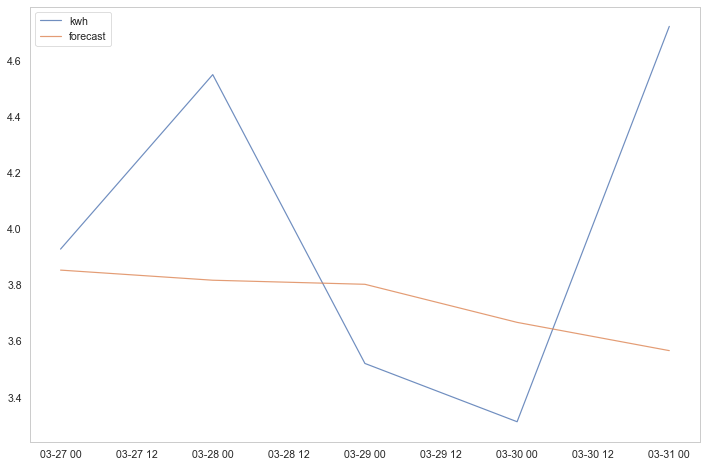

In [23]:
# Making the prediction on the validation set
# Only applicable if train_test_split in the conf.yml > 0
yhat = deep_learner.predict()

if len(yhat) > 0:

    # Constructing the forecast dataframe
    fc = d.tail(len(yhat)).copy()
    fc.reset_index(inplace=True)
    fc['forecast'] = yhat

    # Ploting the forecasts
    plt.figure(figsize=(12, 8))
    for dtype in ['kwh', 'forecast']:
        plt.plot(
            'Datetime',
            dtype,
            data=fc,
            label=dtype,
            alpha=0.8
        )
    plt.legend()
    plt.grid()
    plt.show() 

In [24]:
# IMP Series for predictions; extracted from test split
#fc['forecast']
# Series for expected; extracted from test split
#fc['kwh']

In [25]:
#Accuracy metrics for the forecast: forecast bias, mean absolute error, mean squared error, and root mean square error
expected = fc['kwh']
predictions = fc['forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
#print('Forecast Errors: %s' % forecast_errors)
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

Bias: 0.265519
MAE: 0.520158
MSE: 0.416995
RMSE: 0.645752


In [26]:
# Forecasting n steps ahead   

# Creating the model using full data and forecasting n steps ahead
deep_learner = DeepModelTS(
    data=d, 
    Y_var='kwh',
    lag=24,
    LSTM_layer_depth=64,
    epochs=100,
    train_test_split=0 
)

# Fitting the model 
deep_learner.LSTModel()

# Forecasting n steps ahead
n_ahead = 7
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/100
48/48 [==============================] - 4s 76ms/step - loss: 19.0743 - acc: 0.0208
Epoch 2/100
48/48 [==============================] - 0s 521us/step - loss: 18.6523 - acc: 0.0208
Epoch 3/100
48/48 [==============================] - 0s 562us/step - loss: 18.1814 - acc: 0.0208
Epoch 4/100
48/48 [==============================] - 0s 562us/step - loss: 17.6994 - acc: 0.0208
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 17.1873 - acc: 0.0208
Epoch 6/100
48/48 [==============================] - 0s 729us/step - loss: 16.6903 - acc: 0.0208
Epoch 7/100
48/48 [==============================] - 0s 791us/step - loss: 16.2058 - acc: 0.0208
Epoch 8/100
48/48 [==============================] - 0s 770us/step - loss: 15.7309 - acc: 0.0208
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 15.2640 - acc: 0.0208
Epoch 10/100
48/48 [==============================] - 0s 604us/step - loss: 14.8030 - acc: 0.0208
Epoch 11/100
48/48 [==============

Epoch 83/100
48/48 [==============================] - 0s 770us/step - loss: 1.0838 - acc: 0.0000e+00
Epoch 84/100
48/48 [==============================] - 0s 708us/step - loss: 1.0592 - acc: 0.0000e+00
Epoch 85/100
48/48 [==============================] - 0s 708us/step - loss: 1.0327 - acc: 0.0000e+00
Epoch 86/100
48/48 [==============================] - 0s 1ms/step - loss: 1.0018 - acc: 0.0000e+00
Epoch 87/100
48/48 [==============================] - 0s 583us/step - loss: 0.9726 - acc: 0.0000e+00
Epoch 88/100
48/48 [==============================] - 0s 770us/step - loss: 0.9430 - acc: 0.0000e+00
Epoch 89/100
48/48 [==============================] - 0s 854us/step - loss: 0.9184 - acc: 0.0000e+00
Epoch 90/100
48/48 [==============================] - 0s 1ms/step - loss: 0.9063 - acc: 0.0000e+00
Epoch 91/100
48/48 [==============================] - 0s 791us/step - loss: 0.9010 - acc: 0.0000e+00
Epoch 92/100
48/48 [==============================] - 0s 812us/step - loss: 0.8776 - acc: 0.000

In [28]:
# Constructing the forecast dataframe
fc = d.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(days=x + 1) for x in range(n_ahead)], 
    'kwh': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

KeyError: 'Datetime'

ValueError: x and y must have same first dimension, but have shapes (1,) and (72,)

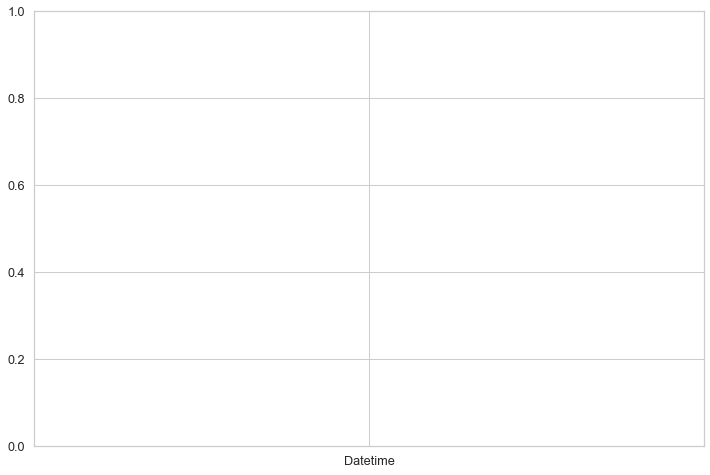

In [24]:
# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'kwh', 
        data=fc[fc['type']==col_type],
        label=col_type
        )